In [1]:
from cdsgd import DSClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score
import wittgenstein as lw
#pca
from sklearn.decomposition import PCA

In [2]:
uniform = pd.read_csv('../data/uniform_df.csv')
uniform_labels = uniform['labels']
uniform = uniform.drop(columns=['labels'])

In [3]:
scaler = StandardScaler()
uniform_scaled = scaler.fit_transform(uniform)
uniform = pd.DataFrame(uniform_scaled, columns=uniform.columns)
models = []
kmeans = KMeans(n_clusters=2)
kmeans_labels = kmeans.fit_predict(uniform)
models.append({'model': kmeans, 'name': 'KMeans', 'labels': kmeans_labels})
print('Kmeans Silhouette Score:', silhouette_score(uniform, kmeans_labels), "Number of Clusters:", len(np.unique(kmeans_labels)))

agg = AgglomerativeClustering(n_clusters=2)
agg_labels = agg.fit_predict(uniform)
models.append({'model': agg, 'name': 'Agglomerative', 'labels': agg_labels})
print('Agglomerative Silhouette Score:', silhouette_score(uniform, agg_labels), "Number of Clusters:", len(np.unique(agg_labels)))

Kmeans Silhouette Score: 0.6092631731974703 Number of Clusters: 2
Agglomerative Silhouette Score: 0.6008471293304397 Number of Clusters: 2


## Lime

In [4]:
clustterToExplain = 1
i = 100 # instance to explain

#KMeans
y = (kmeans_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(uniform, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(uniform, y)
print('KMeans Accuracy:', accuracy_score(y, clf.predict(uniform)))
explainer = LimeTabularExplainer(uniform.values, mode='classification', feature_names=uniform.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(uniform.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

#Agglomerative
y = (agg_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(uniform, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(uniform, y)
print('Agglomerative Accuracy:', accuracy_score(y, clf.predict(uniform)))
explainer = LimeTabularExplainer(uniform.values, mode='classification', feature_names=uniform.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(uniform.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

KMeans Accuracy: 0.998


c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Agglomerative Accuracy: 0.994


c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Decision tree

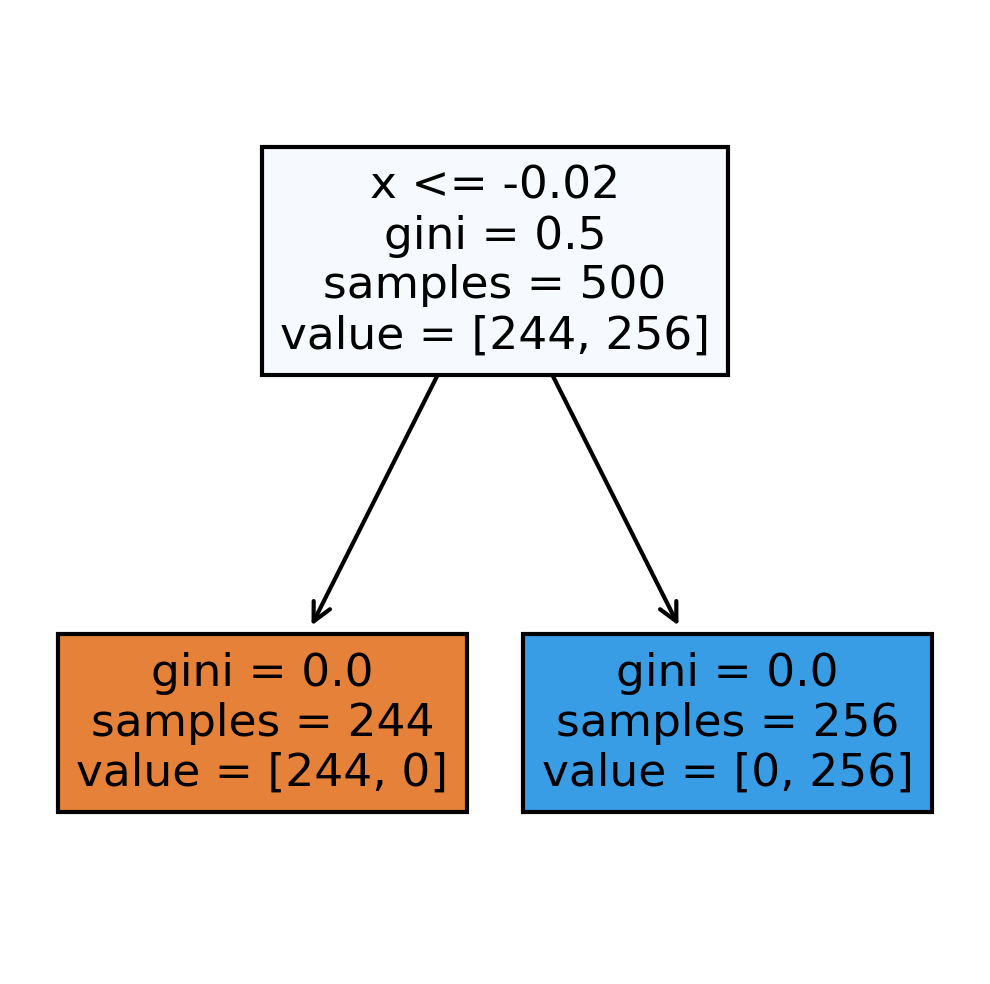

Decision Tree Accuracy: 1.0


In [5]:
# interpretamos con decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(uniform, kmeans_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=uniform.columns)
plt.show()
y_pred = dt.predict(uniform)
print('Decision Tree Accuracy:', accuracy_score(kmeans_labels, y_pred))


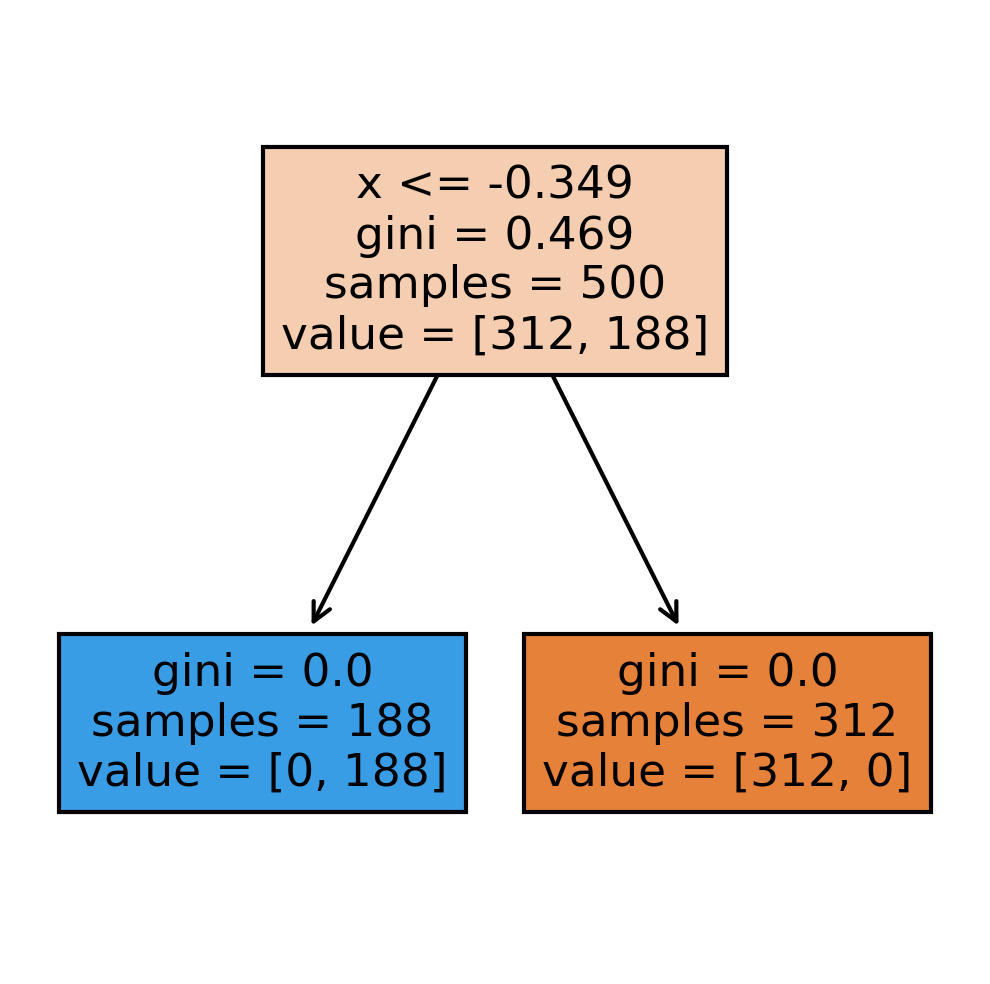

Decision Tree Accuracy: 1.0


In [6]:
# interpretamos con decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(uniform, agg_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=uniform.columns)
plt.show()
y_pred = dt.predict(uniform)
print('Decision Tree Accuracy:', accuracy_score(agg_labels, y_pred))

# RIPPER

In [13]:
pos = 1
# cambiamos las etiquetas para que el positivo sea el cluster 0
kmeans_labels_pos = (kmeans_labels == pos).astype(int)
agg_labels_pos = (agg_labels == pos).astype(int)
# KMeans
ripper = lw.RIPPER()
df = pd.concat([uniform, pd.DataFrame(kmeans_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(uniform)
print('RIPPER Accuracy KMeans:', accuracy_score(kmeans_labels_pos, y_pred))
# Agglomerative
ripper = lw.RIPPER()
df = pd.concat([uniform, pd.DataFrame(agg_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(uniform)
print('RIPPER Accuracy Agglomerative:', accuracy_score(agg_labels_pos, y_pred))

[[x=0.68-1.0] V [x=1.0-1.34] V [x=0.33-0.68] V [x=0.03-0.33] V [x=>1.34]]
RIPPER Accuracy KMeans: 0.988
[[x=-1.4--1.04] V [x=<-1.4] V [x=-1.04--0.67] V [x=-0.67--0.27]]
RIPPER Accuracy Agglomerative: 0.976


## DSClustering

Optimization started
Processing epoch	373	0.0024	

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Training time: 20.99s, epochs: 400

Least training loss reached: 0.002


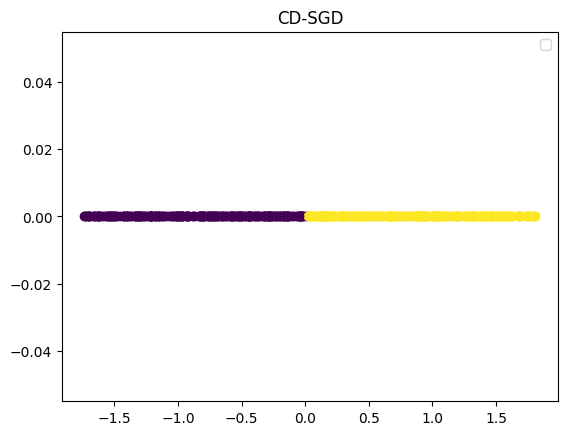

In [8]:
cdsgd = DSClustering(data=uniform,cluster=2)
cdsgd.generate_categorical_rules()
cdsgd_labels = cdsgd.predict()
models.append({'model': cdsgd, 'name': 'CD-SGD con 2 clusters', 'labels': cdsgd_labels})
#vvisualize the clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(uniform)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cdsgd_labels, cmap='viridis')
plt.title('CD-SGD')
plt.legend()
plt.show()

In [9]:
cdsgd.print_most_important_rules()



Most important rules for Cluster 0

	[0.695] R6: -0.089 < x < 0.591
			0: 0.695	1: 0.000	Unc: 0.305

	[0.671] R7: x > 0.591
			0: 0.671	1: 0.000	Unc: 0.329

Most important rules for Cluster 1

	[0.654] R4: x < -0.770
			0: 0.000	1: 0.654	Unc: 0.346

	[0.588] R5: -0.770 < x < -0.089
			0: 0.000	1: 0.588	Unc: 0.412


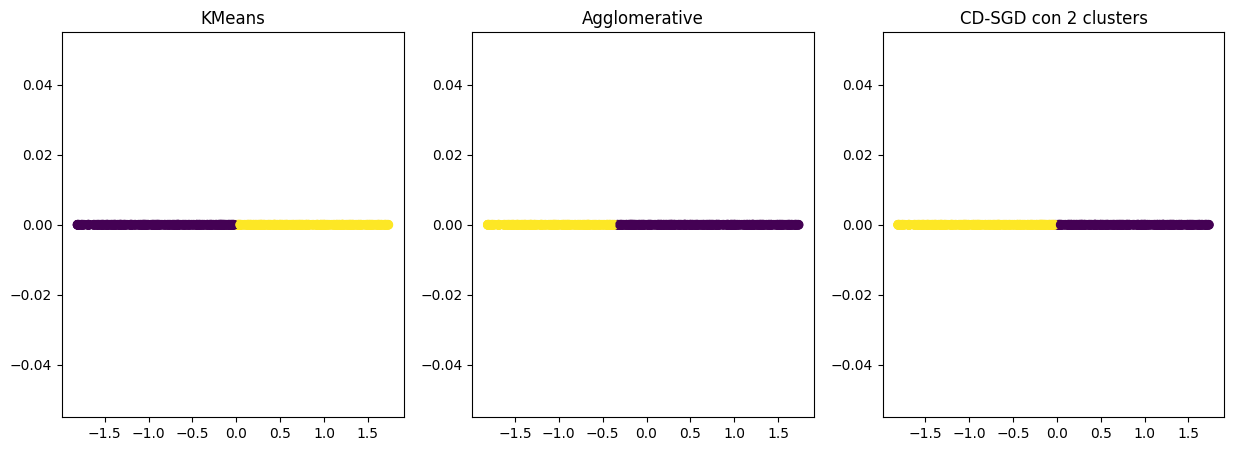

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(models):
    ax[i].scatter(uniform.iloc[:, 0], uniform.iloc[:, 1], c=model['labels'], cmap='viridis')
    ax[i].set_title(model['name'])
plt.show()